# Arijit has taken over this work. 

In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

In [31]:
!ls ../../npys

4epix_Lab6_231103.poni	 det_img2.npy		  jungfrau.npy
det_img0.npy		 det_img2_Sibeee_new.npy  jungfrau_run29.npy
det_img0_Sibeee_new.npy  det_img2_Sibeee.npy	  jungfrau_run30.npy
det_img0_Sibeee.npy	 det_img3.npy		  jungfrau_run31.npy
det_img1.npy		 det_img3_Sibeee_new.npy  Lab5_asselmbles.npy
det_img1_Sibeee_new.npy  det_img3_Sibeee.npy
det_img1_Sibeee.npy	 det_img4_Sibeee_new.npy


In [2]:
# Load the h5 file
with h5.File("/sdf/data/lcls/ds/xpp/xppl1001021/hdf5/smalldata/xppl1001021_Run0035.h5", 'r') as sourceFile:
# with h5.File("/sdf/data/lcls/ds/xpp/xpplx9221/hdf5/smalldata/xpplx9221_Run0242.h5", 'r') as sourceFile:
    #names = list(sourceFile['/epicsAll/det_x'].keys())
    #for name in names:
    #    print(name)
    
    epix1 = np.array(sourceFile['/Sums/epix_alc1_calib'])
    epix2 = np.array(sourceFile['/Sums/epix_alc2_calib'])
    epix3 = np.array(sourceFile['/Sums/epix_alc3_calib'])
    epix4 = np.array(sourceFile['/Sums/epix_alc4_calib'])

In [32]:
epix1 = np.load("../../npys/det_img0_Sibeee_new.npy")
epix2 = np.load("../../npys/det_img1_Sibeee_new.npy")
epix3 = np.load("../../npys/det_img2_Sibeee_new.npy")
epix4 = np.load("../../npys/det_img3_Sibeee_new.npy")

In [33]:
def assemble_image(imgs):
    """
    return the assembled image of size [2080,2080]
    with the 4 epix
    input: list of 4 epix map
    output: map of size (2080,2080) assembled
    """
    shape = [704,768]
    edge  = [170,140]
    frame = np.zeros([2080,2080])
    #epix1
    frame[  edge[0]:shape[0]+edge[0],  edge[1]:shape[1]+edge[1]] = np.rot90( imgs[0] , 2)
    #epix2
    frame[  edge[0]:shape[0]+edge[0],-edge[1]-shape[1]:-edge[1]] = np.rot90( imgs[1] , 2)
    #epix3
    frame[-edge[0]-shape[0]:-edge[0],  edge[1]:shape[1]+edge[1]] = imgs[2]
    #epix4
    frame[-edge[0]-shape[0]:-edge[0],-edge[1]-shape[1]:-edge[1]] =  imgs[3] 
    return frame

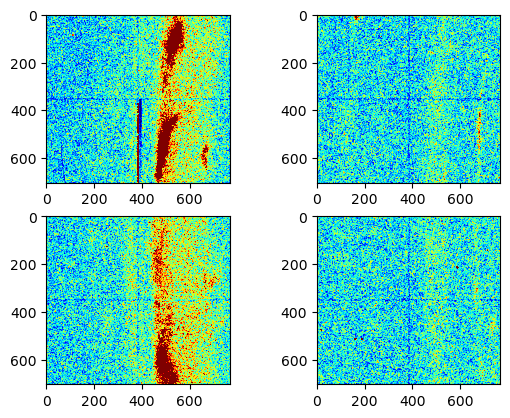

In [34]:
low = 0
high = 1

fig, axes= plt.subplots(ncols=2, nrows=2)
axes[0,0].imshow(epix1[::-1, ::-1], cmap='jet', vmin=low, vmax=high)
axes[0,1].imshow(epix2[::-1, ::-1], cmap='jet', vmin=low, vmax=high)
axes[1,0].imshow(epix3, cmap='jet', vmin=low, vmax=high)
axes[1,1].imshow(epix4, cmap='jet', vmin=low, vmax=high)

plt.show()

# Fit the center of the ring

In [37]:
frame = assemble_image([epix1,epix2,epix3,epix4])
mask = np.ones_like(frame)
mask[500:1000,1700:] = 0
mask[:,:1000] = 0

In [38]:
np.shape(frame)

(2080, 2080)

In [39]:
!ls ../../npys/

4epix_Lab6_231103.poni	 det_img1_Sibeee.npy	  det_img4_Sibeee_new.npy
AhBh_asselmbles.npy	 det_img2.npy		  jungfrau.npy
det_img0.npy		 det_img2_Sibeee_new.npy  jungfrau_run29.npy
det_img0_Sibeee_new.npy  det_img2_Sibeee.npy	  jungfrau_run30.npy
det_img0_Sibeee.npy	 det_img3.npy		  jungfrau_run31.npy
det_img1.npy		 det_img3_Sibeee_new.npy  Lab5_asselmbles.npy
det_img1_Sibeee_new.npy  det_img3_Sibeee.npy


In [44]:
np.save("../../npys/AhBh_asselmbles.npy", frame)

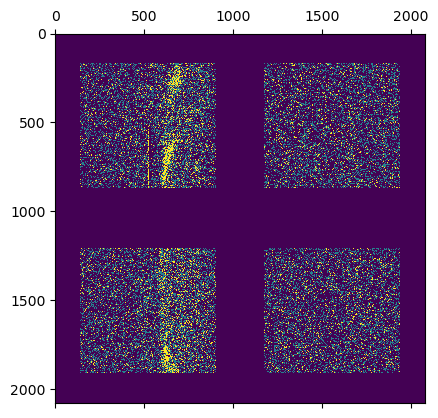

In [43]:
fig, ax = plt.subplots()
ax.matshow(frame,vmin=.2,vmax=2,cmap='viridis')
plt.show()

### Poni

In [25]:
import pyFAI

In [30]:
# pyFAI.load("../../npys/4epix_Lab6_231103.poni")

Detector Detector	 Spline= None	 PixelSize= 5.000e-05, 5.000e-05 m
Wavelength= 1.305097e-10m
SampleDetDist= 1.500000e+00m	PONI= -3.894493e-01, -4.969215e-01m	rot1=-0.687379  rot2= 0.259269  rot3= 0.000003 rad
DirectBeamDist= 2007.820mm	Center: x=14689.758, y=2506.084 pix	Tilt=41.662 deg  tiltPlanRotation= 22.686 deg

In [75]:
selected_pixel = (mask*frame > 1000)*(mask*frame < 1100)
xcoor, ycoor = np.where(selected_pixel == True)

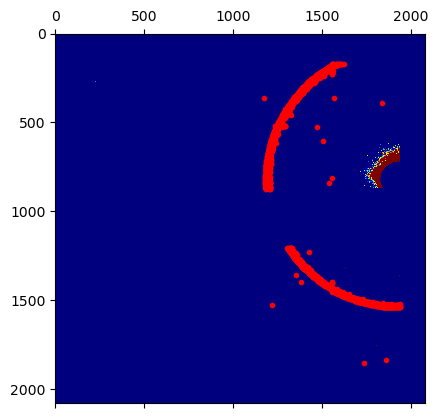

In [76]:
fig, ax = plt.subplots()
ax.matshow(frame,vmin=800,vmax=1100,cmap='jet')
ax.scatter(ycoor, xcoor, c='r', marker='.')
plt.show()

In [80]:
# Fitting the center
#! python
# == METHOD 1 ==
method_1 = 'algebraic'

# coordinates of the barycenter
x_m = np.mean(xcoor)
y_m = np.mean(ycoor)

# calculation of the reduced coordinates
u = xcoor - x_m
v = ycoor - y_m

# linear system defining the center (uc, vc) in reduced coordinates:
#    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
#    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
Suv  = sum(u*v)
Suu  = sum(u**2)
Svv  = sum(v**2)
Suuv = sum(u**2 * v)
Suvv = sum(u * v**2)
Suuu = sum(u**3)
Svvv = sum(v**3)

# Solving the linear system
A = np.array([ [ Suu, Suv ], [Suv, Svv]])
B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
uc, vc = np.linalg.solve(A, B)

xc_1 = x_m + uc
yc_1 = y_m + vc

# Calcul des distances au centre (xc_1, yc_1)
Ri_1     = np.sqrt((xcoor-xc_1)**2 + (ycoor-yc_1)**2)
R_1      = np.mean(Ri_1)
residu_1 = np.sum((Ri_1-R_1)**2)

In [91]:
print("The center position in pixel is ", xc_1, yc_1)
print("The radius in circle is", R_1)

The center position in pixel is  812.9391386934965 1912.1455488502193
The radius in circle is 718.6588143780245


# Assemble the detectors

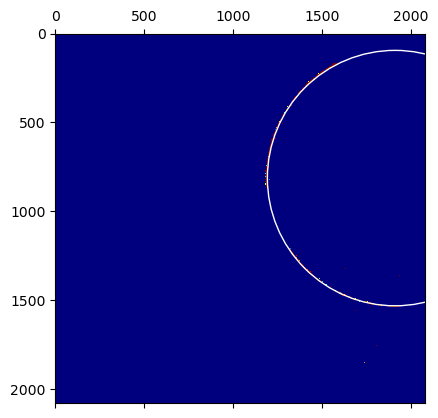

In [90]:
fig, ax = plt.subplots()
ax.matshow(frame * mask,vmin=1000,vmax=1100,cmap='jet')
circle = plt.Circle((yc_1, xc_1), R_1, color='white', fill=False)
ax.add_patch(circle)
plt.show()

# Get the Qmap

In [96]:
def get_pixel_position(det_dist = 1.59e6):  # All the lengths are in um
    
    # Calibrated location
    det_centers = [1912.1455488502193, 812.9391386934965]
    
    # Assign pixel positions
    pixel_position_holder = np.zeros((2080, 2080, 3))
    pixel_position_holder[:,:,2] = det_dist
    pixel_position_holder[:,:,0] = (np.arange(2080) - det_centers[1])[:, np.newaxis] * 50
    pixel_position_holder[:,:,1] = (np.arange(2080) - det_centers[0])[np.newaxis, :] * 50

    return pixel_position_holder

def get_pixel_Q(wavelength, pixel_position):

    # Get angle with respect to incident beam
    pixel_direction = pixel_position / (np.linalg.norm(pixel_position, axis=-1))[:,:,np.newaxis]

    # Get the k_out direction
    Q_direction = np.copy(pixel_direction)
    Q_direction[:,:,2] -= 1

    # Get the Q 
    q_map = np.pi * 2 / wavelength * Q_direction
    q_map = np.linalg.norm(q_map, axis=-1)
    return q_map

In [97]:
det_pixel_pos = get_pixel_position()
det_q_map = get_pixel_Q(wavelength=12.397 / 9.5, pixel_position=det_pixel_pos)

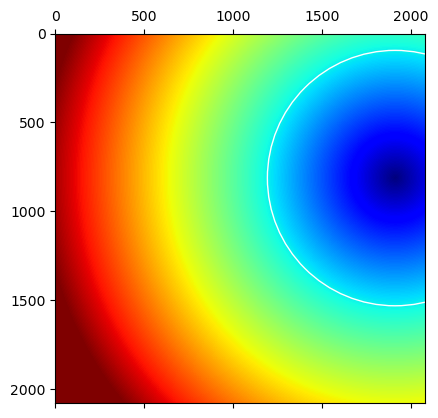

In [98]:
fig, ax = plt.subplots()
ax.matshow(det_q_map,vmin=0,vmax=0.3,cmap='jet')
circle = plt.Circle((yc_1, xc_1), R_1, color='white', fill=False)
ax.add_patch(circle)
plt.show()

# Get the Qmap per epix

In [99]:
def disassemble_image(image):
    
    shape = [704,768]
    edge  = [170,140]

    img1 = image[shape[0] + edge[0]: edge[0]: -1, shape[1]+edge[1]: edge[1]: -1]
    img2 = image[shape[0] + edge[0]: edge[0]: -1, -edge[1]: -edge[1]-shape[1]: -1]
    img3 = image[-edge[0] - shape[0]: -edge[0], edge[1]: shape[1] + edge[1]]
    img4 = image[-edge[0] - shape[0]: -edge[0],-edge[1] - shape[1] : -edge[1]]
    return (img1, img2, img3, img4)

In [100]:
epix1_qmap, epix2_qmap, epix3_qmap, epix4_qmap = disassemble_image(det_q_map)

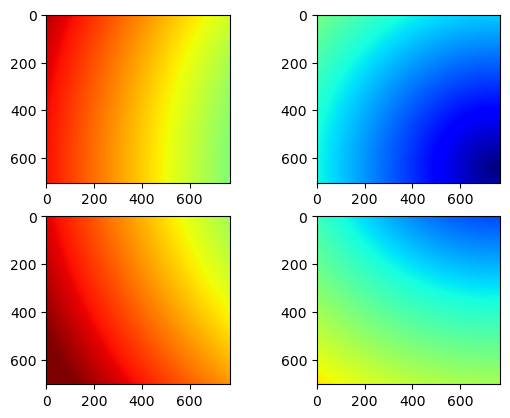

In [102]:
low = 100
high = 1000

qlow = 0
qhigh = 0.3

fig, axes= plt.subplots(ncols=2, nrows=2)
axes[0,0].imshow(epix1_qmap[::-1, ::-1], cmap='jet', vmin=qlow, vmax=qhigh)
axes[0,1].imshow(epix2_qmap[::-1, ::-1], cmap='jet', vmin=qlow, vmax=qhigh)
axes[1,0].imshow(epix3_qmap, cmap='jet', vmin=qlow, vmax=qhigh)
axes[1,1].imshow(epix4_qmap, cmap='jet', vmin=qlow, vmax=qhigh)

plt.show()

In [103]:
np.save("qMap_2023_10_26_assembled.npy", det_q_map)
np.save("qMap_2023_10_26_ePix1.npy", epix1_qmap)
np.save("qMap_2023_10_26_ePix2.npy", epix2_qmap)
np.save("qMap_2023_10_26_ePix3.npy", epix3_qmap)
np.save("qMap_2023_10_26_ePix4.npy", epix4_qmap)

In [104]:
pwd

'/sdf/data/lcls/ds/xpp/xpplx9221/results/haoyuan'